<a href="https://colab.research.google.com/github/sbhusal123/Advanced-Web-Scraping/blob/main/CS224_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224N: Hugging Face Transformers Tutorial (Winter '22)


* [Hugging Face Course](https://huggingface.co/course/)




In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

In [ ]:
!pip install transformers
!pip install datasets

## Part 0: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

![full_nlp_pipeline.png](attachment:full_nlp_pipeline.png)
From [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [ ]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm excited to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7605,  2.9262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### 0.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padd

In [ ]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]


In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 Hugging Face Transformers is great!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 1632, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is great! [SEP]


In [ ]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(input_str)

print(input_str)
print("-"*5)
print(f"Number of tokens: {len(inputs)}")
print(f"Ids: {inputs.ids}")
print(f"Tokens: {inputs.tokens}")
print(f"Special tokens mask: {inputs.special_tokens_mask}")
print()
print("char_to_word gives the wordpiece of a character in the input")
char_idx = 8
print(f"For example, the {char_idx + 1}th character of the string is '{input_str[char_idx]}',"+\
      f" and it's part of wordpiece {inputs.char_to_token(char_idx)}, '{inputs.tokens[inputs.char_to_token(char_idx)]}'")

Hugging Face Transformers is great!
-----
Number of tokens: 9
Ids: [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
Tokens: ['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 1]

char_to_word gives the wordpiece of a character in the input
For example, the 9th character of the string is 'F', and it's part of wordpiece 3, 'Face'


In [ ]:
# Other cool tricks:
# The tokenizer can return pytorch tensors
model_inputs = tokenizer("Hugging Face Transformers is great!", return_tensors="pt")
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [ ]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


In [ ]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes."]


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 0.2 Models




Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
![model_illustration.png](attachment:model_illustration.png)


Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [ ]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [ ]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0163, -0.1588]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.5437, 0.4563]], grad_fn=<SoftmaxBackward0>)


If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

These models are just Pytorch Modules! You can can calculate the loss with your `loss_func` and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used

In [ ]:
# You can calculate the loss like normal
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

tensor(0.7845, grad_fn=<NllLossBackward0>)


('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
          -4.6824e-02, -9.4855e-03],
         [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
          -3.7862e-02, -2.4103e-02],
         [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
          -3.5670e-02, -3.1419e-02],
         ...,
         [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
          -4.6263e-02, -1.6803e-02],
         [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
          -1.1252e-02, -2.2152e-02],
         [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
          -4.3556e-02,  1.0529e-04]], requires_grad=True))

Hugging Face provides an additional easy way to calculate the loss as well:

In [ ]:
# To calculate the loss, we need to pass in a label:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)


print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

SequenceClassifierOutput(loss=tensor(0.7845, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0163, -0.1588]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: NEGATIVE


One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)

print()

print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key

print()
print(model_output)

Hidden state size (per layer):   torch.Size([1, 9, 768])

Attention head size (per layer): torch.Size([1, 12, 9, 9])

BaseModelOutput(last_hidden_state=tensor([[[ 0.2965,  0.1076,  0.0469,  ...,  0.0507,  0.2053,  0.0773],
         [-0.0459, -0.1005,  0.0340,  ...,  0.2486, -0.0583,  0.0148],
         [-0.0177,  0.0837,  0.1960,  ...,  0.1960, -0.0752, -0.3148],
         ...,
         [ 0.1862,  0.0908,  0.1282,  ...,  0.4653, -0.1436,  0.1785],
         [ 0.3360,  0.2323,  0.3822,  ...,  0.3867,  0.0377,  0.3314],
         [ 0.7182,  0.7498,  0.3507,  ...,  0.3424,  0.7111,  0.0599]]]), hidden_states=(tensor([[[ 0.5521,  0.1778, -0.0585,  ..., -0.0160,  0.2085, -0.1154],
         [-0.2170, -0.9449, -1.3180,  ...,  1.2498,  0.1091, -0.4434],
         [-0.7837, -0.4800,  0.4499,  ..., -0.3740, -0.7640,  0.7910],
         ...,
         [-0.9263,  0.0137, -0.4151,  ..., -0.5369, -0.6277,  0.8462],
         [-0.5610,  0.9675,  0.8943,  ...,  0.7401, -1.1003,  0.0229],
         [-0.4382,  0

['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']


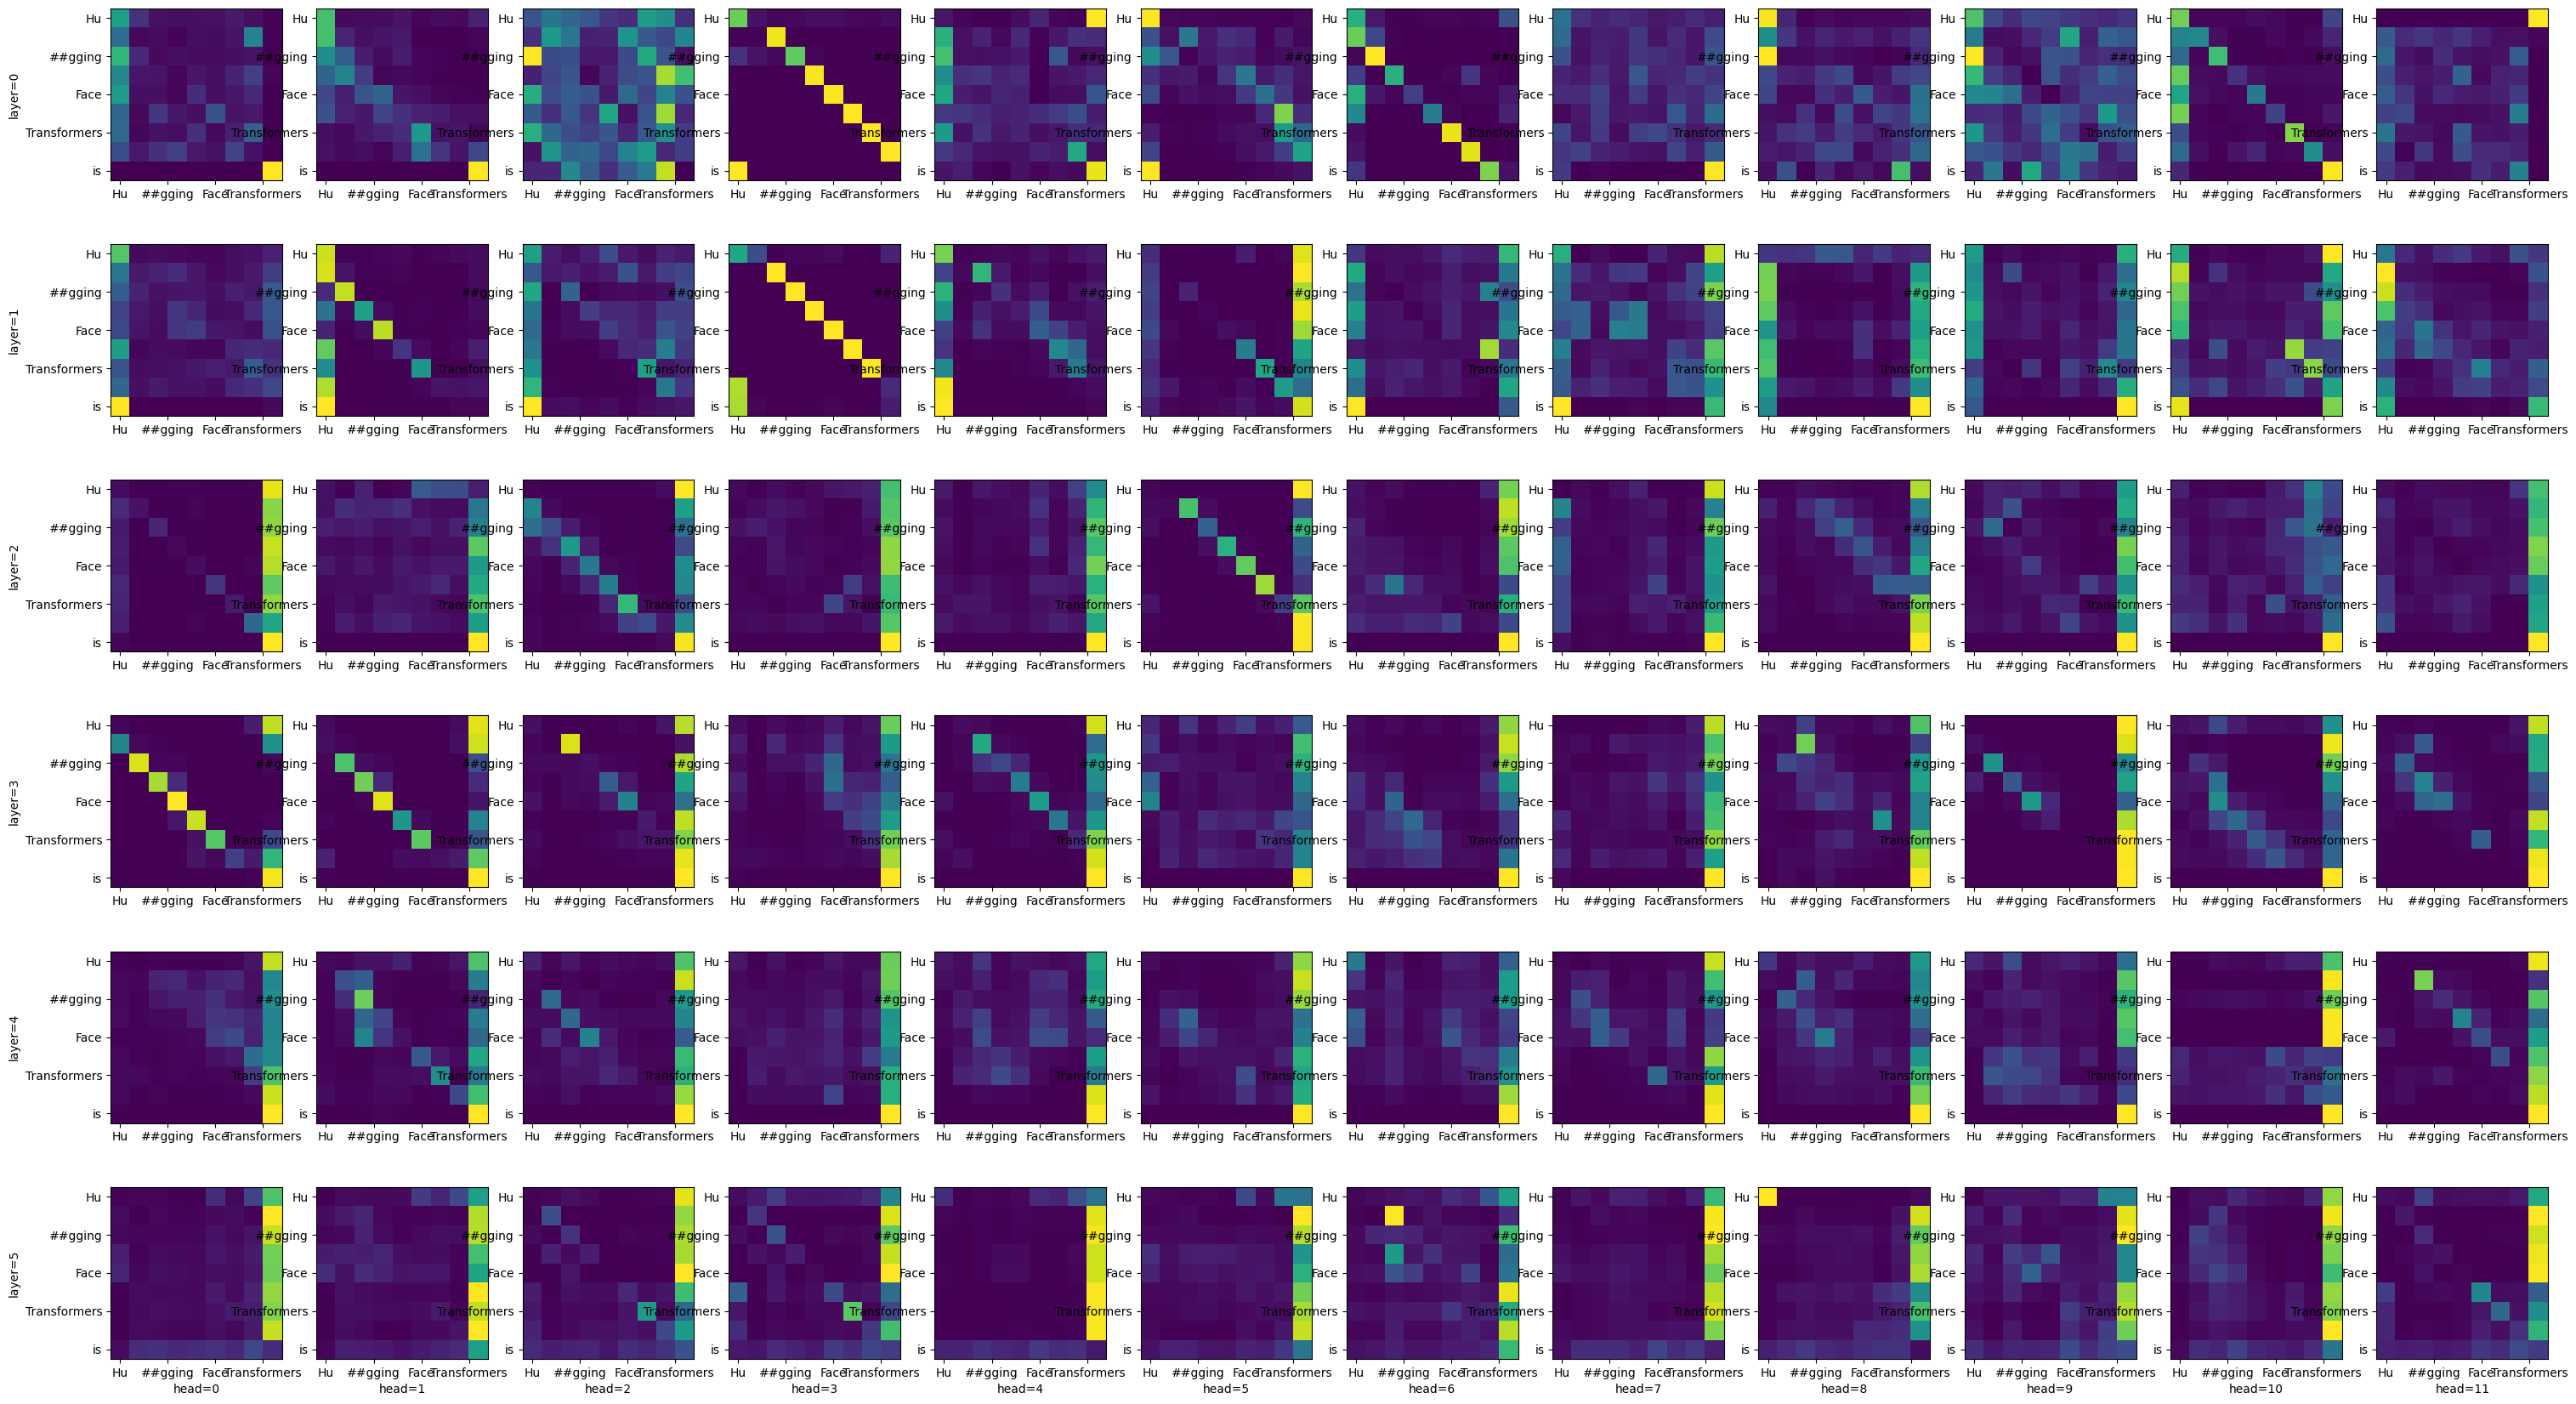

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        # axes[layer][i].set_xticks(list(range(10)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="horizontal")
        # axes[layer][i].set_yticks(list(range(10)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.2)
plt.show()